In [1]:
import ROOT as root
import numpy as np
import random
from timer import Timer

t = Timer()
t.start()

ModuleNotFoundError: No module named 'ROOT'

In [2]:
fileName = "data/AnaBarMC_7001.root"
treeName = "T"

f = root.TFile(fileName)
myTree = f.Get(treeName)

myTree.Print()

root.EnableImplicitMT()
d = root.RDataFrame(treeName,fileName)

myGeometryData = myTree.GetUserInfo().FindObject("myGeometryData")

******************************************************************************
*Tree    :T         : Output Tree                                            *
*Entries :      100 : Total =        60620821 bytes  File  Size =     643164 *
*        :          : Tree compression factor =  97.14                       *
******************************************************************************
*Br    0 :Prim_E    : Prim_E/F                                               *
*Entries :      100 : Total  Size=        959 bytes  File Size  =        455 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.03     *
*............................................................................*
*Br    1 :Prim_X    : Prim_X/F                                               *
*Entries :      100 : Total  Size=        959 bytes  File Size  =        470 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

In [3]:
#myGeometryData.Print()
print(myGeometryData[0])
print(myGeometryData[0][0])
print(myGeometryData[0][1])
print(myGeometryData[0][2])
print(myGeometryData[0][3])
print(myGeometryData[1][0])
print(myGeometryData[1][1])
print(myGeometryData[1][2])
print(myGeometryData[1][3])
print(len(myGeometryData))
type(myGeometryData)

Name: TVectorT<double> Title: 
0.0
450.0
0.0
1497.5
1.0
450.0
0.0
1492.0999755859375
2352


<class cppyy.gbl.TList at 0x113e26610>

In [4]:
root.gInterpreter.ProcessLine('#include "AnalyseSignalsRDataFrameNoKE.h"')

0

In [5]:
fdf = d.Define("trigger", "getTrigger(Detector_Nhits, &Detector_id[0])") \
       .Define("fMass", "getMass(Prim_pdg)") \
       .Define("fMomentum","getMomentum(Prim_E,fMass)") \
       .Define("fPx", "getPx(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPy", "getPy(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPz", "getPz(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fNewTheta", "getNewTheta(fMomentum,fPy)") \
       .Define("fNewPhi", "getNewPhi(fMomentum,fPx,fPz)") \
       .Define("trigger2", "getTrigger2(trigger,fNewTheta)") \
       .Define("trigger3", "getTrigger3(trigger,fNewTheta)") \
       .Define("fingerXVec","getFingerXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("fingerYVec","getFingerYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("fingerZVec","getFingerZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("fingerTVec","getFingerTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)") \
       .Define("anaBarXVec","getAnaBarXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("anaBarYVec","getAnaBarYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("anaBarZVec","getAnaBarZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("anaBarTVec","getAnaBarTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)") \
       .Define("fingerID","getFingerID(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("fingerPDG","getFingerPDG(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarID","getAnaBarID(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarPDG","getAnaBarPDG(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarPMTID","getAnaBarPMTID(trigger,&PMT_Nphotons[0])") \
       .Define("fingerPMTID","getFingerPMTID(trigger,&PMT_Nphotons[0])") \
       .Define("fingerPMTNPhotons","getFingerPMTNPhotons(trigger,&PMT_Nphotons[0])") \
       .Define("anaBarPMTNPhotons","getAnaBarPMTNPhotons(trigger,&PMT_Nphotons[0])") \
       .Define("anaBarXPMT","getAnaBarXPMT(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarZPMT","getAnaBarZPMT(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarPXPMT","getAnaBarPXPMT(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarPZPMT","getAnaBarPZPMT(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarPMTTime","getAnaBarPMTTime(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarPMTTimeOverThreshold","getAnaBarPMTTimeOverThreshold(trigger,&PMT_Nphotons[0],&PMT_TimeOverThreshold[0])") \
       .Define("anaBarPMTTimeTop","getAnaBarPMTTimeTop(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarPMTTimeBottom","getAnaBarPMTTimeBottom(trigger,&PMT_Nphotons[0],&PMT_Time[0])") \
       .Define("anaBarNPhotonsTotal","getAnaBarNPhotonsTotal(trigger,&PMT_Nphotons[0])") \
       .Define("imult","getAnaBarMult(trigger,&PMT_Nphotons[0])") \
       .Define("fingerEd","getFingerEd(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])") \
       .Define("anaBarEd","getAnaBarEd(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])") \
       .Define("anaBarEdTotal","getAnaBarEdTotal(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])")

triggers = fdf.Filter("trigger==true").Count()
print('{} entries passed trigger'.format(triggers.GetValue()))

fdft = fdf.Filter("trigger==true")

100 entries passed trigger


Info in <TCanvas::Print>: pdf file plots/c1.pdf has been created


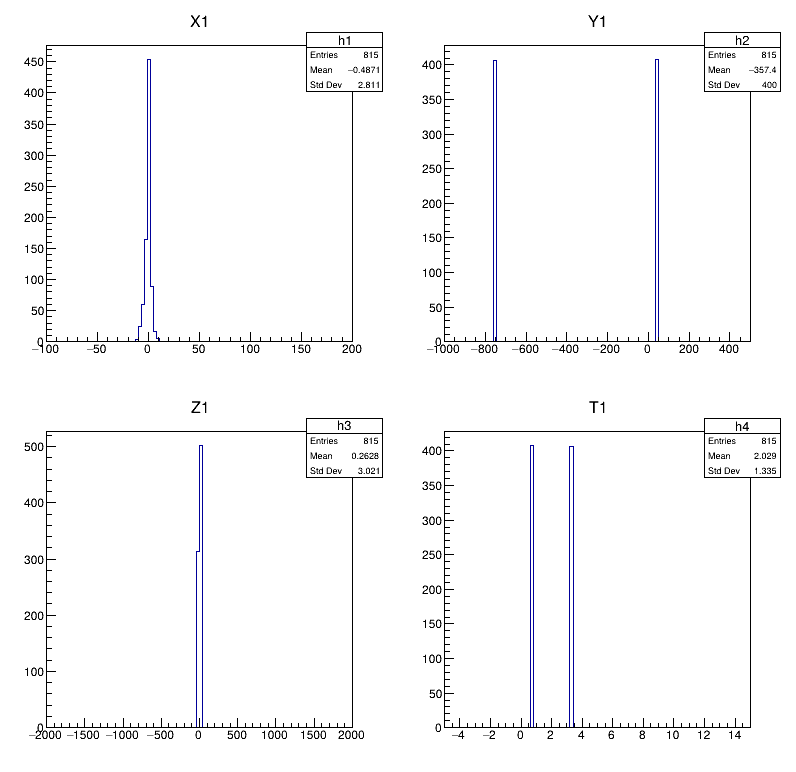

In [6]:
# Canvas 1
hFingerX = fdft.Histo1D(("h1", "X1", 100, -100.0, 200.0),'fingerXVec')
hFingerY = fdft.Histo1D(("h2", "Y1", 100, -1000.0, 500.0),'fingerYVec')
hFingerZ = fdft.Histo1D(("h3", "Z1", 100, -2000.0, 2000.0),'fingerZVec')
hFingerT = fdft.Histo1D(("h4", "T1", 100, -5.0, 15.0),'fingerTVec')

c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
hFingerX.Draw()
c1.cd(2)
hFingerY.Draw()
c1.cd(3)
hFingerZ.Draw()
c1.cd(4)
hFingerT.Draw()

c1.Draw()
c1.Print("plots/c1.pdf");

Info in <TCanvas::Print>: pdf file plots/c2.pdf has been created


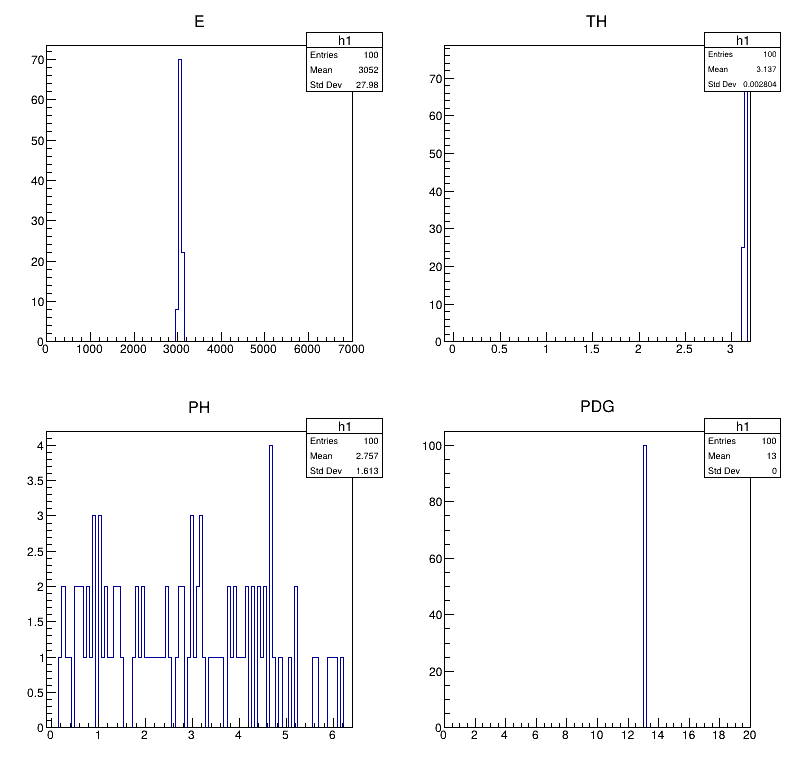

In [7]:
# Canvas 2

hPrimE = fdft.Histo1D(("h1", "E", 100, 0.0, 7000.0),'Prim_E')
hPrimTh = fdft.Histo1D(("h1", "TH", 100, -0.1, 3.2),'fNewTheta')
hPrimPh = fdft.Histo1D(("h1", "PH", 100, -0.1, 6.4),'fNewPhi')
hPrimPdg = fdft.Histo1D(("h1", "PDG", 100, 0.0, 20.0),'Prim_pdg')

c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
hPrimE.Draw()
c2.cd(2)
hPrimTh.Draw()
c2.cd(3)
hPrimPh.Draw()
c2.cd(4)
hPrimPdg.Draw()

c2.Draw()
c2.Print("plots/c2.pdf")


In [8]:
def plotSinglePoints(hist):

    x1 = 60.0;
    y1 = 115.0;
    x2 = 70.0;
    y2 = 125.0;
    opacity = 0.9;
    rect7 = root.TBox(x1, y1, x2, y2);
    rect7.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect7);
    x1 = 60.0;
    y1 = -115.0;
    x2 = 70.0;
    y2 = -125.0;
    opacity = 0.9;
    rect8 = root.TBox(x1, y1, x2, y2);
    rect8.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect8);
    x1 = -35.0;
    y1 = -5.0;
    x2 = -45.0;
    y2 = 5.0;
    opacity = 0.9;
    rect9 = root.TBox(x1, y1, x2, y2);
    rect9.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect9);
    x1 = -5.0;
    y1 = 55.0;
    x2 = 5.0;
    y2 = 65.0;
    opacity = 0.9;
    rect10 = root.TBox(x1, y1, x2, y2);
    rect10.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect10);
    x1 = -5.0;
    y1 = -55.0;
    x2 = 5.0;
    y2 = -65.0;
    opacity = 0.9;
    rect11 = root.TBox(x1, y1, x2, y2);
    rect11.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect11);
    x1 = 25.0;
    y1 = -85.0;
    x2 = 35.0;
    y2 = -95.0;
    opacity = 0.9;
    rect12 = root.TBox(x1, y1, x2, y2);
    rect12.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect12);
    x1 = 25.0;
    y1 = 85.0;
    x2 = 35.0;
    y2 = 95.0;
    opacity = 0.9;
    rect13 = root.TBox(x1, y1, x2, y2);
    rect13.SetFillColorAlpha(3, opacity);
    hist.GetListOfFunctions().Add(rect13);

In [9]:
def plotDetector(hist):
    
    opacity=0.2
    x1 = 55.0
    y1 = -61.6
    x2 = -45.2
    y2 = -8.74
    rect1 = root.TBox(x1, y1, x2, y2)
    rect1.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect1)
    x1 = 55.0
    y1 = -8.74
    x2 = -45.2
    y2 = 44.14
    rect2 = root.TBox(x1, y1, x2, y2)
    rect2.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect2)
    x1 = 62.5
    y1 = -114.54
    x2 = -37.7
    y2 = -61.62
    rect3 = root.TBox(x1, y1, x2, y2)
    rect3.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect3)
    x1 = 70.0
    y1 = -167.46
    x2 = -30.2
    y2 = -114.54
    rect4 = root.TBox(x1, y1, x2, y2);
    rect4.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect4);
    x1 = 62.5
    y1 = 44.14
    x2 = -37.7
    y2 = 97.50
    rect5 = root.TBox(x1, y1, x2, y2)
    rect5.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect5)
    x1 = 70.0
    y1 = 97.50
    x2 = -30.2
    y2 = 150.0
    rect6 = root.TBox(x1, y1, x2, y2)
    rect6.SetFillColorAlpha(2, opacity)
    hist.GetListOfFunctions().Add(rect6)

Info in <TCanvas::Print>: pdf file plots/c33.pdf has been created


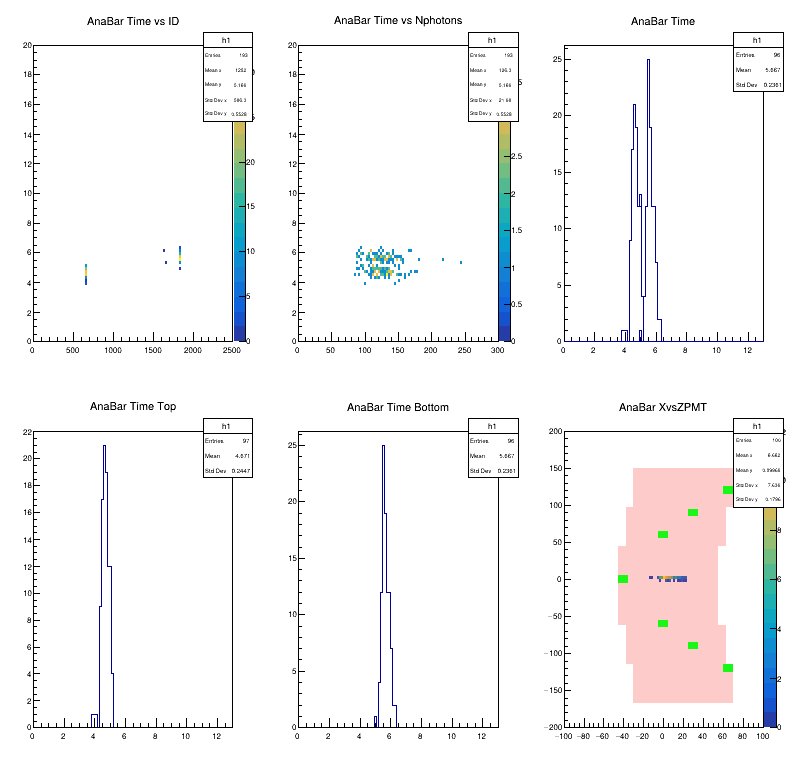

In [10]:
# Canvas 33
hAnaBarPMTTime_vs_ID = fdft.Histo2D(("h1", "AnaBar Time vs ID", 100, 0.0, 2500.0,100,0.0,20.0),'anaBarPMTID','anaBarPMTTime')
hAnaBarPMTTime = fdft.Histo1D(("h1", "AnaBar Time", 100, 0.0, 13.0),'anaBarPMTTime')
hAnaBarPMTTimeTop = fdft.Histo1D(("h1", "AnaBar Time Top", 100, 0.0, 13.0),'anaBarPMTTimeTop')
hAnaBarPMTTimeBottom = fdft.Histo1D(("h1", "AnaBar Time Bottom", 100, 0.0, 13.0),'anaBarPMTTimeBottom')
hAnaBarPMTTime_vs_Nphoton = fdft.Histo2D(("h1", "AnaBar Time vs Nphotons", 100, 0.0, 300.0,100,0.0,20.0),'anaBarPMTNPhotons','anaBarPMTTime')
hAnaBarXZPMT = fdft.Histo2D(("h1","AnaBar XvsZPMT",100,-100.0,100.0,100,-200,200),"anaBarXPMT","anaBarZPMT");

c33 = root.TCanvas("c33","c33",800,800)
c33.Divide(3,2,0.01,0.01,0)

c33.cd(1)
hAnaBarPMTTime_vs_ID.Draw("COLZ")
c33.cd(2)
hAnaBarPMTTime_vs_Nphoton.Draw("COLZ")
c33.cd(3)
hAnaBarPMTTime.Draw()
hAnaBarPMTTimeTop.Draw("SAME")
hAnaBarPMTTimeBottom.Draw("SAME")
c33.cd(4)
hAnaBarPMTTimeTop.Draw()
c33.cd(5)
hAnaBarPMTTimeBottom.Draw()
c33.cd(6)
hAnaBarXZPMT.Draw("COLZ")
plotDetector(hAnaBarXZPMT)
plotSinglePoints(hAnaBarXZPMT)

c33.Draw()
c33.Print("plots/c33.pdf")


In [12]:
# Canvas 333
#hAnaBarPMTTimeOverThreshold_vs_ID = fdft.Histo2D(("h1", "AnaBar Time Over Threshold vs ID", 100, 0.0, 2500.0,100,0.0,50.0),'anaBarPMTID','anaBarPMTTimeOverThreshold')
#hAnaBarPMTTimeOverThreshold = fdft.Histo1D(("h1", "AnaBar Time Over Threshold", 100, 0.0, 50.0),'anaBarPMTTimeOverThreshold')
##hAnaBarPMTTimeTop = fdft.Histo1D(("h1", "AnaBar Time Top", 100, 0.0, 13.0),'anaBarPMTTimeTop')
##hAnaBarPMTTimeBottom = fdft.Histo1D(("h1", "AnaBar Time Bottom", 100, 0.0, 13.0),'anaBarPMTTimeBottom')
#hAnaBarPMTTimeOverThreshold_vs_Nphoton = fdft.Histo2D(("h1", "AnaBar Time Over Threshold vs Nphotons", 100, 0.0, 300.0,100,0.0,50.0),'anaBarPMTNPhotons','anaBarPMTTimeOverThreshold')
#hAnaBarXZPMT = fdft.Histo2D(("h1","AnaBar XvsZPMT",100,-100.0,100.0,100,-200,200),"anaBarXPMT","anaBarZPMT")

#c333 = root.TCanvas("c33","c33",800,800)
#c333.Divide(2,2,0.01,0.01,0)

#c333.cd(1)
#hAnaBarPMTTimeOverThreshold_vs_ID.Draw("COLZ")
#c333.cd(2)
#hAnaBarPMTTimeOverThreshold_vs_Nphoton.Draw("COLZ")
#c333.cd(3)
#hAnaBarPMTTimeOverThreshold.Draw()
##hAnaBarPMTTimeTop.Draw("SAME")
##hAnaBarPMTTimeBottom.Draw("SAME")
##c33.cd(4)
##hAnaBarPMTTimeTop.Draw()
##c33.cd(5)
##hAnaBarPMTTimeBottom.Draw()
#c333.cd(4)
#hAnaBarXZPMT.Draw("COLZ")
##plotDetector(hAnaBarXZPMT)
##plotSinglePoints(hAnaBarXZPMT)
#
#c333.Draw()
#c333.Print("plots/c333.pdf")

Info in <TCanvas::Print>: pdf file plots/c34.pdf has been created


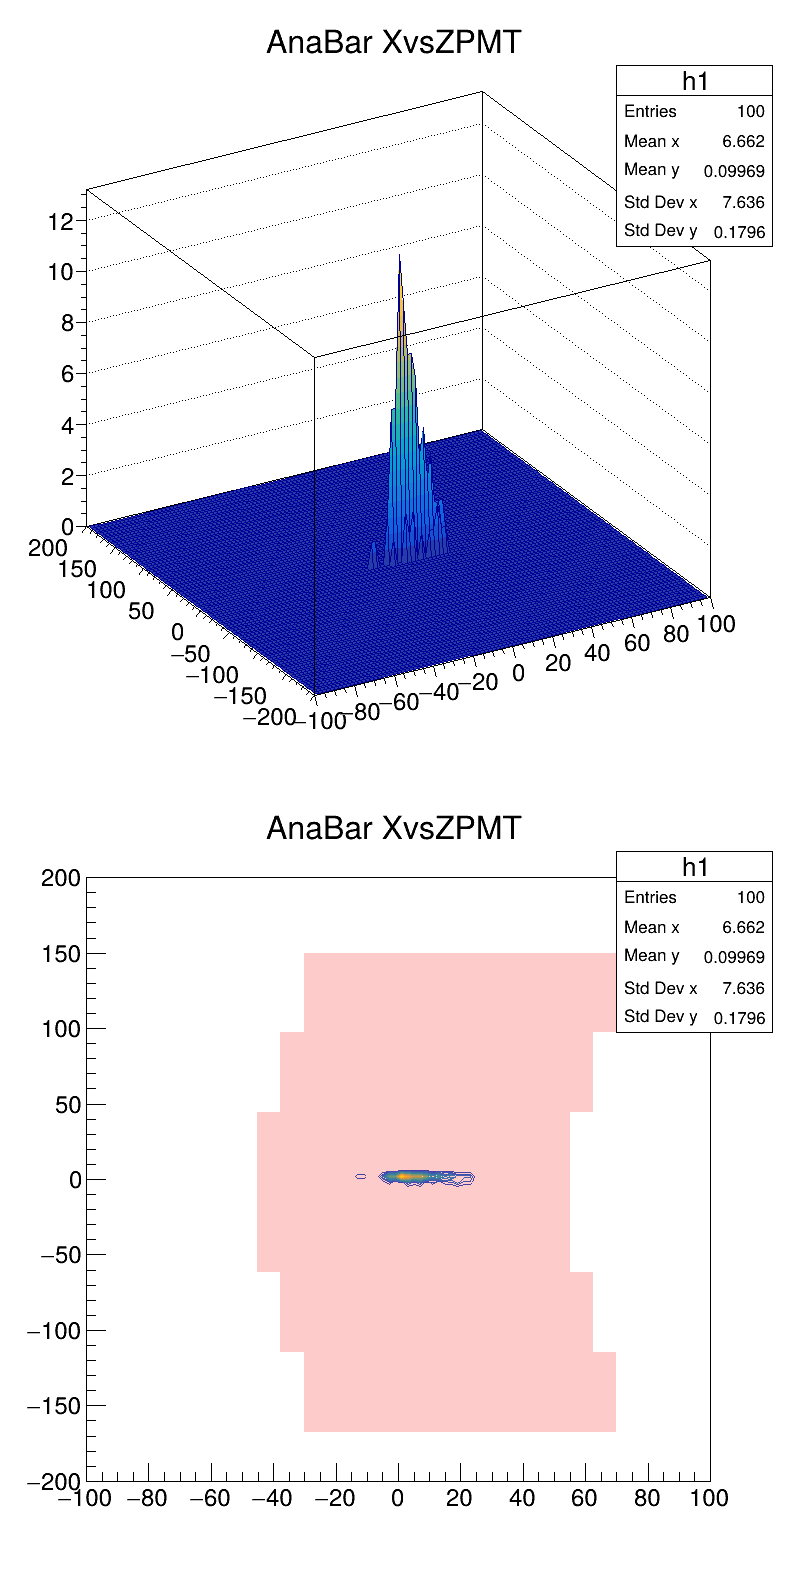

In [13]:
hAnaBarXZPMT = fdft.Histo2D(("h1","AnaBar XvsZPMT",100,-100.0,100.0,100,-200,200),"anaBarXPMT","anaBarZPMT")

c34 = root.TCanvas("c34","c34",800,1600)
c34.Divide(1,2,0.01,0.01,0)

c34.cd(1)
hAnaBarXZPMT.Draw("SURF1")

c34.cd(2)
hAnaBarXZPMT.Draw("CONT1")
plotDetector(hAnaBarXZPMT)
#plotSinglePoints(hAnaBarXZPMT);


                  
c34.Print("plots/c34.pdf");

Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Info in <TCanvas::Print>: pdf file plots/c3.pdf has been created
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000


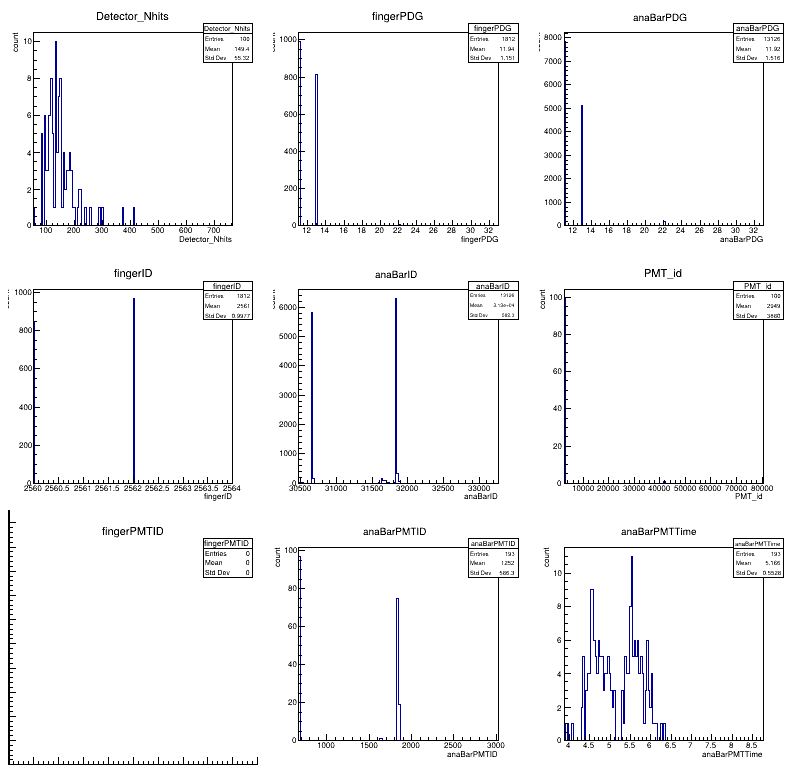

In [14]:
# Canvas 3

hDetectorNhits = fdft.Histo1D('Detector_Nhits')
hDetectorPdg = fdft.Histo1D('anaBarPDG')
hDetectorID = fdft.Histo1D('anaBarID')
hFingerPdg = fdft.Histo1D('fingerPDG')
hFingerID = fdft.Histo1D('fingerID')
hPMTID = fdft.Histo1D('PMT_id')
hAnaBarPMTID = fdft.Histo1D('anaBarPMTID')
hFingerPMTID = fdft.Histo1D('fingerPMTID')
hAnaBarPMTTime = fdft.Histo1D('anaBarPMTTime')

c3 = root.TCanvas("c3","c3",800,800)
c3.Divide(3,3,0.01,0.01,0)

c3.cd(1)
hDetectorNhits.Draw()
c3.cd(2)
hFingerPdg.Draw()
c3.cd(3)
hDetectorPdg.Draw()
c3.cd(4)
hFingerID.Draw()
c3.cd(5)
hDetectorID.Draw()
c3.cd(6)
##hPMTID.GetXaxis().SetRangeUser(0,14)
hPMTID.Draw()
c3.cd(7)
hFingerPMTID.Draw()
c3.cd(8)
hAnaBarPMTID.Draw()
c3.cd(9)
hAnaBarPMTTime.Draw()

c3.Draw()
c3.Print("plots/c3.pdf")


Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used
Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Info in <TCanvas::Print>: pdf file plots/c4.pdf has been created


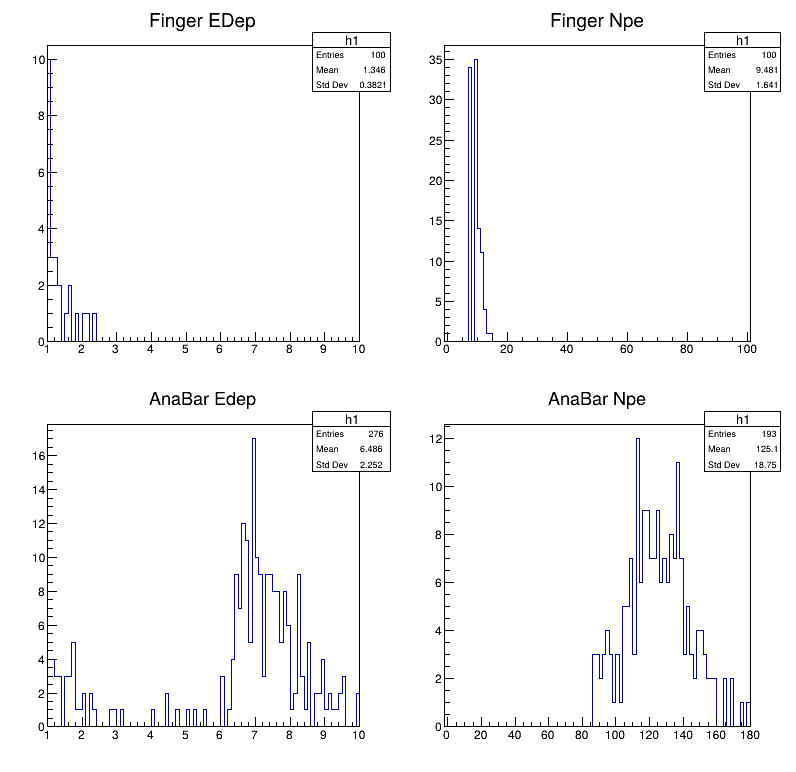

In [15]:
# Canvas 4

hFingerEd = fdft.Histo1D(("h1", "Finger EDep", 100, 0.0, 10.0),'fingerEd')
hFingerPMTNphot = fdft.Histo1D(("h1", "Finger Npe", 100, 0.1, 100.0),'fingerPMTNPhotons')
hAnaBarPMTNphot = fdft.Histo1D(("h1", "AnaBar Npe", 100, 0.1, 200.0),'anaBarPMTNPhotons')
hAnaBarEd = fdft.Histo1D(("h1", "AnaBar Edep", 100, 0.0, 10.0),'anaBarEd')

c4 = root.TCanvas("c4","c4",800,800)

c4.cd()
pad = root.TPad("pad","pad",0.01,0.51,0.50,0.99)
pad.Draw()
pad.cd()
hFingerEd.GetXaxis().SetRangeUser(1.0,10)
hFingerEd.Draw();

c4.cd()
pad = root.TPad("pad","pad",0.51,0.51,0.99,0.99)
pad.Draw()
pad.cd()
hFingerPMTNphot.GetXaxis().SetRangeUser(-10,250)
hFingerPMTNphot.Draw()

c4.cd()
pad = root.TPad("pad","pad",0.01,0.01,0.50,0.50)
#pad.SetLogy()
pad.Draw()
pad.cd()
hAnaBarEd.GetXaxis().SetRangeUser(1.0,10)
hAnaBarEd.Draw();

c4.cd()
pad = root.TPad("pad","pad",0.51,0.01,0.99,0.50)
#pad.SetLogy()
pad.Draw()
pad.cd()
hAnaBarPMTNphot.GetXaxis().SetRangeUser(-20,180)
hAnaBarPMTNphot.Draw()

c4.Draw()
c4.Print("plots/c4.pdf")

Info in <TCanvas::Print>: pdf file plots/c5.pdf has been created


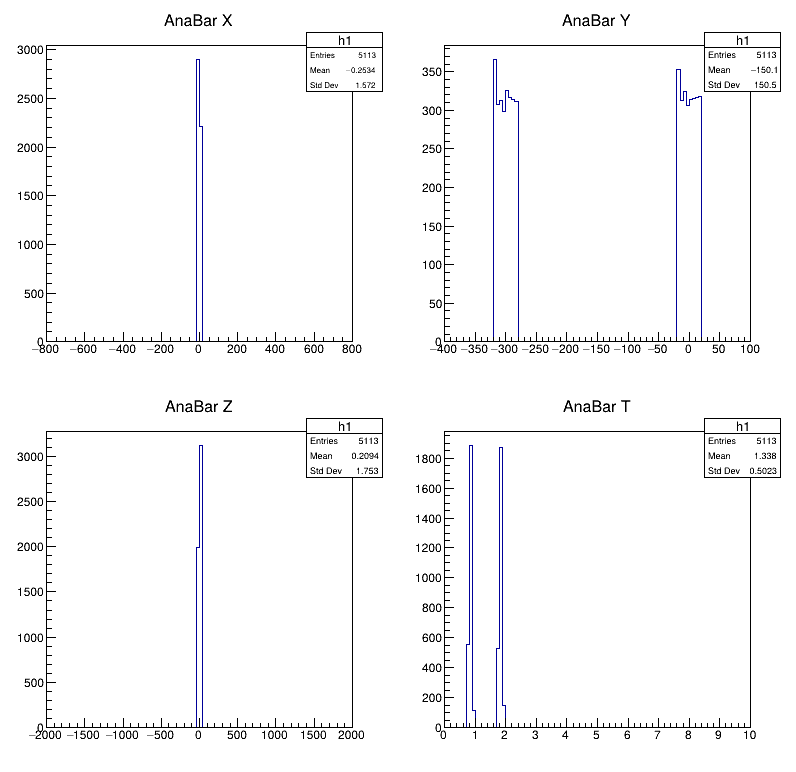

In [16]:
# Canvas 5

hAnaBarX = fdft.Histo1D(("h1", "AnaBar X", 100, -800.0, 800.0),'anaBarXVec')
hAnaBarY = fdft.Histo1D(("h1", "AnaBar Y", 100, -400.0, 100.0),'anaBarYVec')
hAnaBarZ = fdft.Histo1D(("h1", "AnaBar Z", 100, -2000.0, 2000.0),'anaBarZVec')
hAnaBarT = fdft.Histo1D(("h1", "AnaBar T", 100, 0.0, 10.0),'anaBarTVec')

c5 = root.TCanvas("c5","c5",800,800)
c5.Divide(2,2,0.01,0.01,0)

c5.cd(1)
hAnaBarX.Draw()
c5.cd(2)
hAnaBarY.Draw()
c5.cd(3)
hAnaBarZ.Draw()
c5.cd(4)
hAnaBarT.Draw()

c5.Draw()
c5.Print("plots/c5.pdf");

Info in <TCanvas::Print>: pdf file plots/c6.pdf has been created


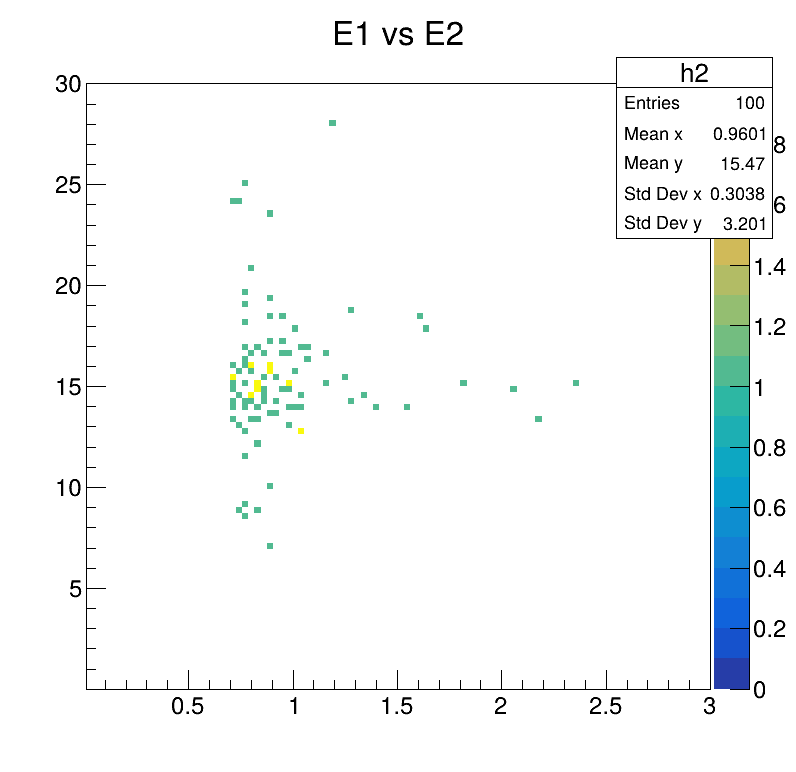

In [17]:
hE1vsE2 = fdft.Histo2D(("h2", "E1 vs E2", 100, 0.01, 3.0, 100, 0.01, 30.0),"fingerEd","anaBarEdTotal")

c6 = root.TCanvas("c6", "c6", 800, 800)
c6.Divide(1,1, 0.01, 0.01, 0)

c6.cd(1)
hE1vsE2.Draw("COLZ")

c6.Draw()
c6.Print("plots/c6.pdf")

In [18]:
hFinger_Edep_vs_Nphot = fdft.Filter("trigger2").Histo2D(("h3", "Finger Edep vs Nphot", 100, 0.01, 200.0, 100, 0.01, 3.0),"fingerPMTNPhotons","fingerEd")
hAnaBar_Edep_vs_Nphot = fdft.Filter("trigger2").Histo2D(("h4", "AnaBar Edep vs NphotTotal", 100, 0.01, 30.0, 100, 0.01, 500.0),"anaBarEdTotal","anaBarNPhotonsTotal")
hNphot0_vs_Nphot = fdft.Filter("trigger2").Histo2D(("h5", "AnaBar NphotTotal vs Finger Nphot", 100, 0.01, 500.0, 100, 0.01, 200.0),"anaBarNPhotonsTotal","fingerPMTNPhotons")

c7 = root.TCanvas("c7", "c7", 800, 800)
c7.Divide(2,2, 0.01, 0.01, 0)

#c7PE_MeV = root.TCanvas("c7PE_MeV", "c7PE_MeV", 800,800)
#c7Profile = root.TCanvas("c7Profile", "c7Profile", 800,800)

c7.cd(1)
hFinger_Edep_vs_Nphot.Draw("COLZ")
c7.cd(2)
hAnaBar_Edep_vs_Nphot.Draw("COLZ")
c7.cd(3)
hNphot0_vs_Nphot.Draw("COLZ")
c7.cd(4)
prof = hAnaBar_Edep_vs_Nphot.ProfileX()
prof.Fit("pol1")

****************************************
Minimizer is Linear / Migrad
Chi2                      =   1.3502e+16
NDf                       =           32
p0                        =     -42.6172   +/-   6.51657e-07 
p1                        =      16.0937   +/-   3.78457e-08 


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

Info in <TCanvas::Print>: pdf file plots/c7.pdf has been created


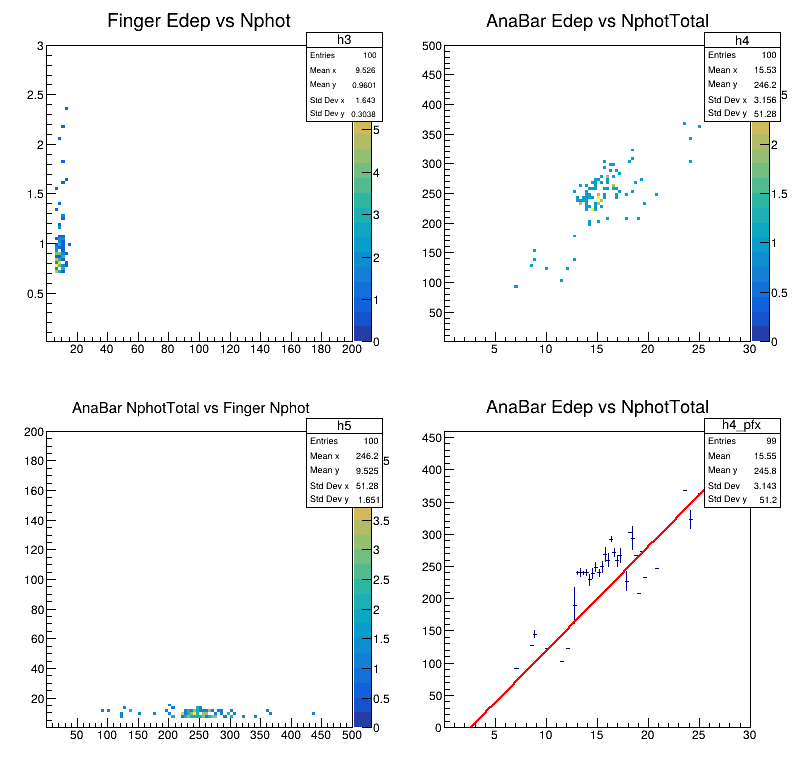

In [19]:
c7.Draw()
c7.Print("plots/c7.pdf")

In [20]:
hFinger_Edep_vs_NphotCut = fdft.Filter("trigger3").Histo2D(("h3", "Finger Edep vs Nphot", 100, 0.01, 200.0, 100, 0.01, 3.0),"fingerPMTNPhotons","fingerEd")
hAnaBar_Edep_vs_NphotCut = fdft.Filter("trigger3").Histo2D(("h4", "AnaBar Edep vs Nphot", 100, 0.01, 30.0, 100, 0.01, 500.0),"anaBarEdTotal","anaBarNPhotonsTotal")
hNphot0_vs_Nphot1Cut = fdft.Filter("trigger3").Histo2D(("h5", "AnaBar Nphot vs Finger Nphot", 100, 0.01, 500.0, 100, 0.01, 200.0),"anaBarNPhotonsTotal","fingerPMTNPhotons")

c8 = root.TCanvas("c8", "c8", 800, 800)
c8.Divide(2,2, 0.01, 0.01, 0)

#c7PE_MeV = root.TCanvas("c7PE_MeV", "c7PE_MeV", 800,800)
#c7Profile = root.TCanvas("c7Profile", "c7Profile", 800,800)

c8.cd(1)
hFinger_Edep_vs_NphotCut.Draw("COLZ")
c8.cd(2)
hAnaBar_Edep_vs_NphotCut.Draw("COLZ")
c8.cd(3)
hNphot0_vs_Nphot1Cut.Draw("COLZ")
c8.cd(4)
prof = hAnaBar_Edep_vs_NphotCut.ProfileX()
prof.Fit("pol1")

****************************************
Minimizer is Linear / Migrad
Chi2                      =   1.3502e+16
NDf                       =           32
p0                        =     -42.6172   +/-   6.51657e-07 
p1                        =      16.0937   +/-   3.78457e-08 


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

Info in <TCanvas::Print>: pdf file plots/c8.pdf has been created


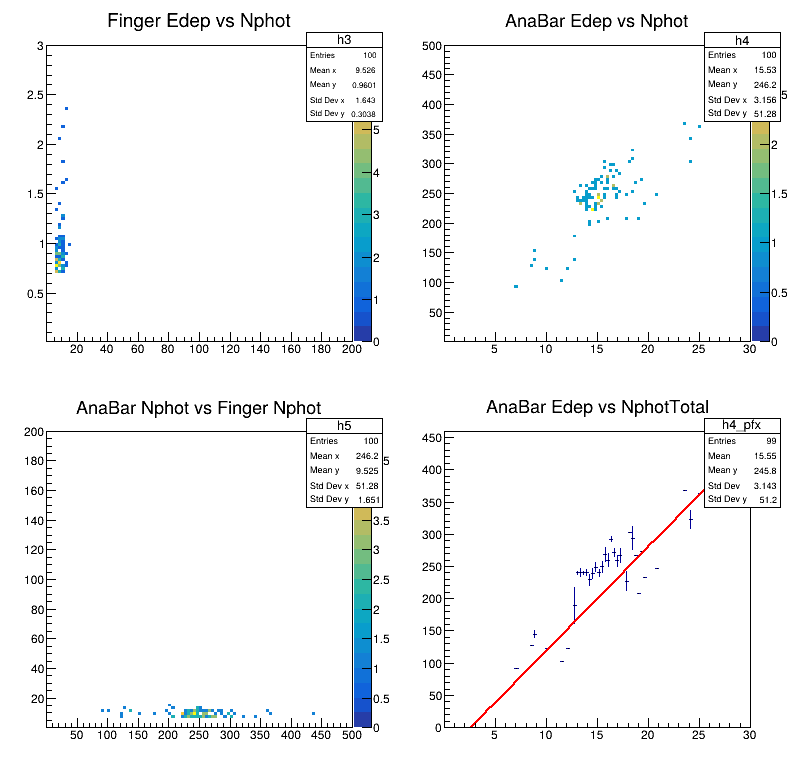

In [21]:
c8.Draw()
c8.Print("plots/c8.pdf")

In [22]:
#NUMPADDLE=14
#
#hAnaBarEdAll = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarEd%d" % i)
#    title = ("AnaBar Energy Deposited A%d" % i)
#    name2 = ("anaBarEd[%d]" %i)
#    hAnaBarEdAll.append(fdft.Define(name,name2).Filter("trigger3").Histo1D((name, title, 100, 0.01, 10.0),name))
#    
#hAnaBarEdAllCut = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarEd%dCut" % i)
#    title = ("AnaBar Energy Deposited A%d" % i)
#    name2 = ("anaBarEd[%d]" %i)
#    name3 = ("trigger3 && anaBarPMTNPhotons[%d]>100.0" % i)
#    hAnaBarEdAllCut.append(fdft.Define(name,name2).Filter(name3).Histo1D((name, title, 100, 0.01, 10.0),name))
#
#cEd = root.TCanvas("cEd", "cEd", 800,800)
#cEd.Divide(4,4)
#
#means = []
#meanErr = []
#
#start = 5.5
#gf = root.TF1("gf", "gaus", start, 10.0)
#
#for i in range(NUMPADDLE):
#    
#    print ("Paddle = ",i+1)
#
#    cEd.cd(i+1)
#    
#    hAnaBarEdAll[i].Draw()
#    hAnaBarEdAllCut[i].SetLineColor(2)
#    hAnaBarEdAllCut[i].Draw("SAME")
#    
#cEd.Draw()
#cEd.Print("plots/cEdRA.pdf")

In [23]:
#hAnaBarPMTNphotArray = []
#
#for i in range(NUMPADDLE):  
#    name = ("AnaBarPMTNphotA%d" % i)
#    title = ("AnaBar_PMT_Number_of_Photons_A%d" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    hAnaBarPMTNphotArray.append(fdft.Define(name,name2).Filter("trigger").Histo1D((name, title, 200, -20, 180.0),name))
#    
#hAnaBarPMTNphotCut = []
#    
#for i in range(NUMPADDLE):  
#    name = ("AnaBarPMTNphotA%dCut" % i)
#    title = ("AnaBar_PMT_Number_of_Photons_A%d_Cut" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    hAnaBarPMTNphotCut.append(fdft.Define(name,name2).Filter("trigger3").Histo1D((name, title, 200, -20, 180.0),name))
#    
#hAnaBarPMTNoiseCutNphot = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarPMTNoiseCutNphotA%d" % i)
#    title = ("AnaBar PMT Number of Photons A%d" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    name3 = ("trigger3 && anaBarEd[%d]>4.0" % i)
#    hAnaBarPMTNoiseCutNphot.append(fdft.Define(name,name2).Filter(name3).Histo1D((name, title, 200, -20, 180.0),name))
#
#c9 = root.TCanvas("c9", "c9", 800,800)
#
#print("Fitting ...\n")
#fr = [float, float]
#fp, fpe = [float, float, float, float], [float, float, float, float]
#pllo = [0.05, 0.5, 1.0, 0.04]
#plhi = [10.0, 50.0, 10000.0, 5.0]
#sv = [1.8, 5.0, 1400.0, 3.0]
#chisqr = float
#ndf = int
#SNRPeak, SNRFWHM = float, float
#
#
#for i in range(NUMPADDLE):
#        c9.cd()
#        xl = 0.25*(i%4)
#        xh = 0.25*(i%4)+0.25
#        yl = 0.75 - 0.25*int(i/4)
#        yh = 0.75 - 0.25*int(i/4) + 0.25
#        #print (i,xl,yl,xh,yh)
#        pad = root.TPad("pad","pad",xl,yl,xh,yh)
#        pad.SetLogy(True)
#        pad.Draw()
#        pad.cd()
#        hAnaBarPMTNphotArray[i].Draw()
#        hAnaBarPMTNoiseCutNphot[i].SetLineColor(2)
#        hAnaBarPMTNoiseCutNphot[i].Draw("SAME")
#        #hAnaBarPMTNoiseCutNphot[i].Fit("gaus")

In [24]:
#c9.Draw()
#c9.Print("plots/c9.pdf")

Info in <TCanvas::Print>: pdf file plots/c11.pdf has been created


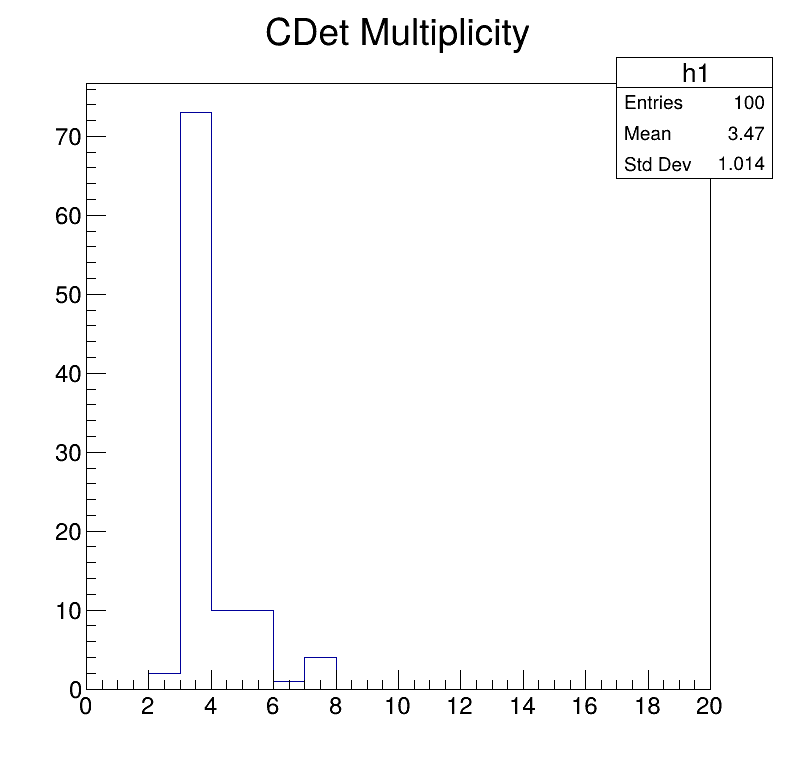

In [25]:
hAnaBarMult = fdft.Histo1D(("h1", "CDet Multiplicity", 20, 0, 20),"imult")

c11 = root.TCanvas("c11", "c11", 800,800)
c11.Divide(1,1, 0.01, 0.01, 0)

c11.cd(1)
hAnaBarMult.Draw()

c11.Draw()
c11.Print("plots/c11.pdf")

Info in <TCanvas::Print>: pdf file plots/c12.pdf has been created


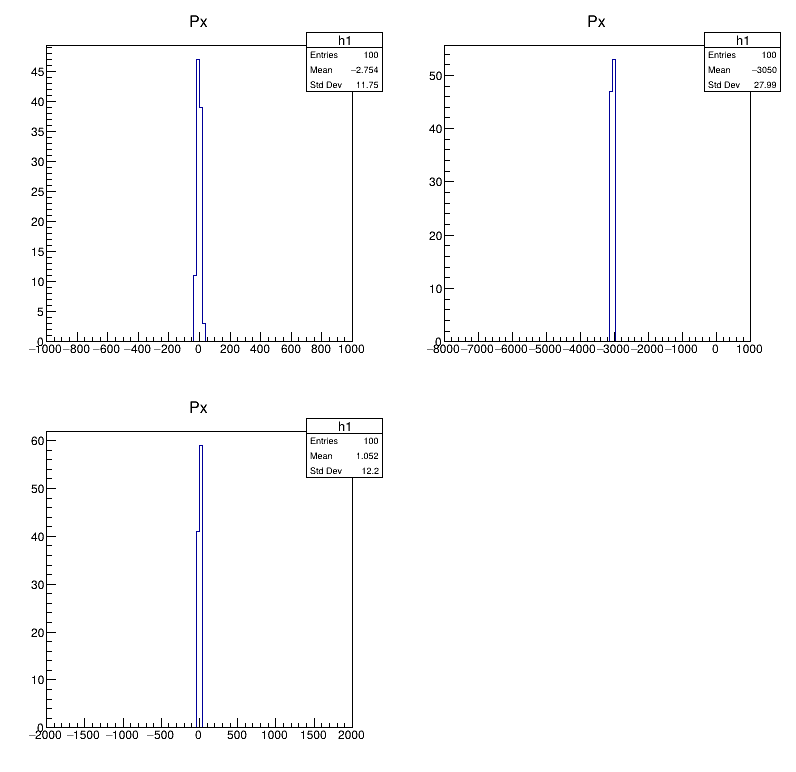

In [26]:

hPrimPx = fdft.Histo1D(("h1", "Px", 100, -1000, 1000),"fPx")
hPrimPy = fdft.Histo1D(("h1", "Px", 100, -8000, 1000),"fPy")
hPrimPz = fdft.Histo1D(("h1", "Px", 100, -2000, 2000),"fPz")

c12 = root.TCanvas("c12", "c12", 800,800)
c12.Divide(2,2, 0.01, 0.01, 0)

c12.cd(1)
hPrimPx.Draw()
c12.cd(2)
hPrimPy.Draw()
c12.cd(3)
hPrimPz.Draw()

c12.Draw()
c12.Print("plots/c12.pdf")

Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Info in <TCanvas::Print>: pdf file plots/c13.pdf has been created
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000


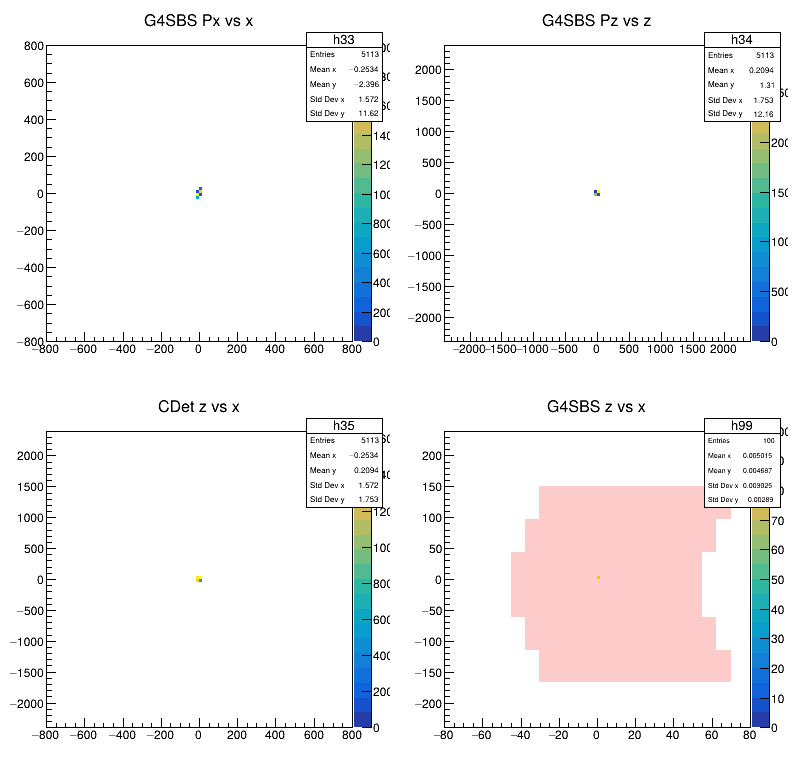

In [27]:
hPx_vs_x = fdft.Filter("trigger2").Histo2D(("h33", "G4SBS Px vs x", 100, -800.0, 800.0, 100, -800.0, 800.0),"anaBarXVec","fPx");
hPz_vs_z = fdft.Filter("trigger2").Histo2D(("h34", "G4SBS Pz vs z", 100, -2400.0, 2400.0, 100, -2400.0, 2400.0),"anaBarZVec","fPz");
hz_vs_x = fdft.Filter("trigger2").Histo2D(("h35", "CDet z vs x", 100, -800.0, 800.0, 100, -2400.0, 2400.0),"anaBarXVec","anaBarZVec");
hPrimXZ = fdft.Histo2D(("h99", "G4SBS z vs x", 100, -80.0, 80.0, 100, -240.0, 240.0),"Prim_X","Prim_Z");
    
c13 = root.TCanvas("c13", "c13", 800, 800)
c13.Divide(2,2, 0.01, 0.01, 0)

c13.cd(1)
hPx_vs_x.Draw("COLZ")
c13.cd(2)
hPz_vs_z.Draw("COLZ")
c13.cd(3)
hz_vs_x.Draw("COLZ")
c13.cd(4)
plotDetector(hPrimXZ);
hPrimXZ.Draw('COLZ')


c13.Draw()
c3.Print("plots/c13.pdf")

Info in <TCanvas::Print>: pdf file plots/c14.pdf has been created


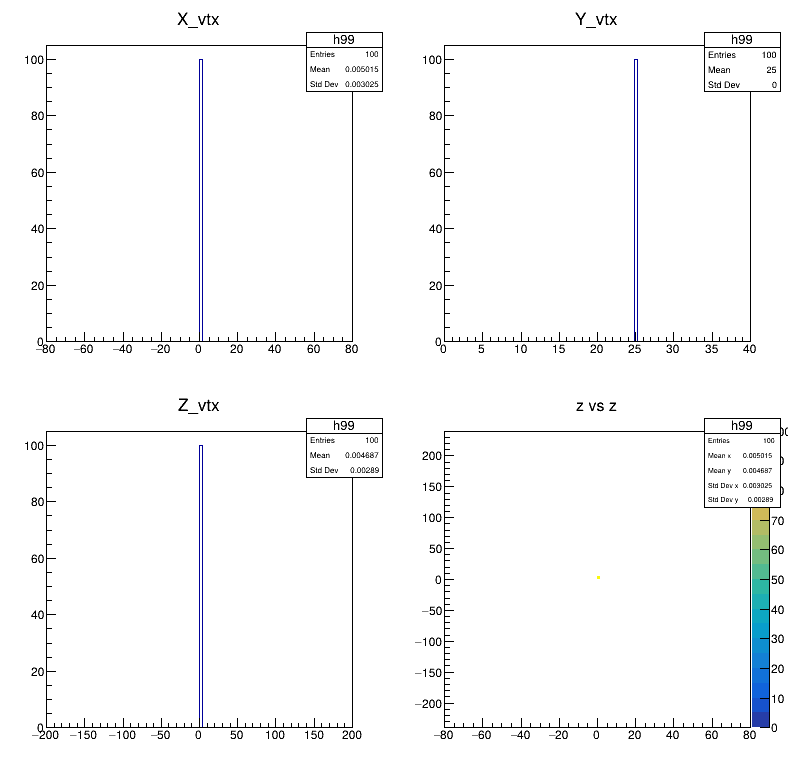

In [28]:
# Canvas 14
hPrimX = fdft.Histo1D(("h99","X_vtx", 100, -80,80),"Prim_X")
hPrimY = fdft.Histo1D(("h99","Y_vtx", 100, 0,40),"Prim_Y")
hPrimZ = fdft.Histo1D(("h99","Z_vtx", 100, -200,200),"Prim_Z")
hPrimXZ = fdft.Histo2D(("h99", "z vs z", 100, -80.0, 80.0, 100, -240.0, 240.0),"Prim_X","Prim_Z")

c14 = root.TCanvas("c14","c14",800,800)
c14.Divide(2,2,0.01,0.01,0)

c14.cd(1)
hPrimX.Draw()
c14.cd(2)
hPrimY.Draw()
c14.cd(3)
hPrimZ.Draw()
c14.cd(4)
hPrimXZ.Draw('COLZ')

c14.Draw()
c14.Print("plots/c14.pdf")

Info in <TCanvas::Print>: pdf file plots/c15.pdf has been created


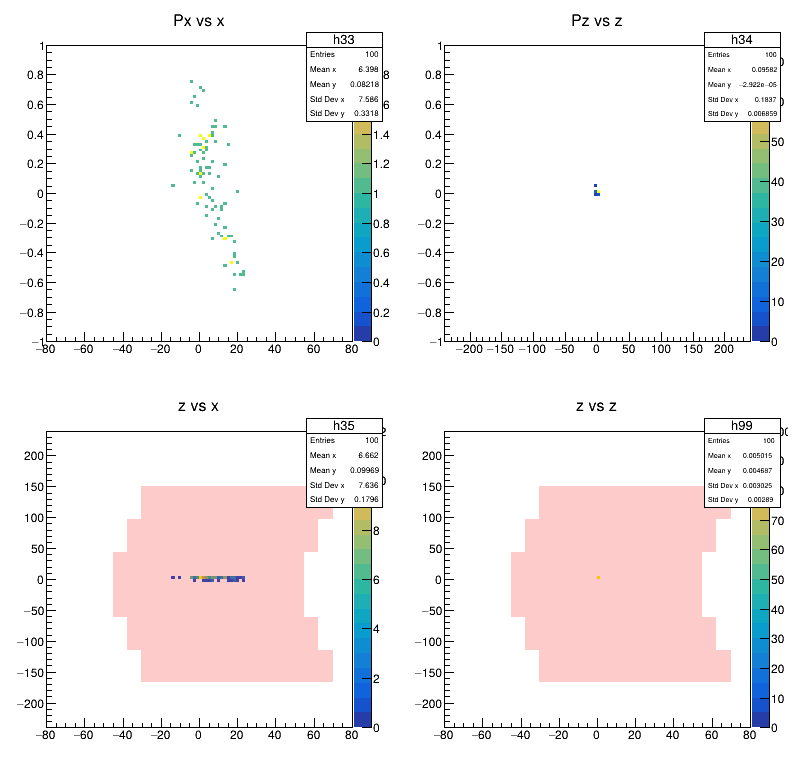

In [29]:
hPx_vs_x = fdft.Filter("trigger2").Histo2D(("h33", "Px vs x", 100, -80.0, 80.0, 100, -1.0, 1.0),"anaBarXPMT","anaBarPXPMT");
hPz_vs_z = fdft.Filter("trigger2").Histo2D(("h34", "Pz vs z", 100, -240.0, 240.0, 100, -1.0, 1.0),"anaBarZPMT","anaBarPZPMT");
hz_vs_x = fdft.Filter("trigger2").Histo2D(("h35", "z vs x", 100, -80.0, 80.0, 100, -240.0, 240.0),"anaBarXPMT","anaBarZPMT");
hPrimXZ = fdft.Histo2D(("h99", "z vs z", 100, -80.0, 80.0, 100, -240.0, 240.0),"Prim_X","Prim_Z");



c15 = root.TCanvas("c15","c15",800,800);
c15.Divide(2,2,0.01,0.01,0);

c15.cd(1);
hPx_vs_x.Draw("COLZ");
c15.cd(2);
hPz_vs_z.Draw("COLZ");
c15.cd(3);
hz_vs_x.Draw("COLZ");
plotDetector(hz_vs_x);
c15.cd(4);
hPrimXZ.Draw("COLZ");
plotDetector(hPrimXZ);

c15.Draw();
c15.Print("plots/c15.pdf");

Info in <TCanvas::Print>: pdf file plots/c16.pdf has been created


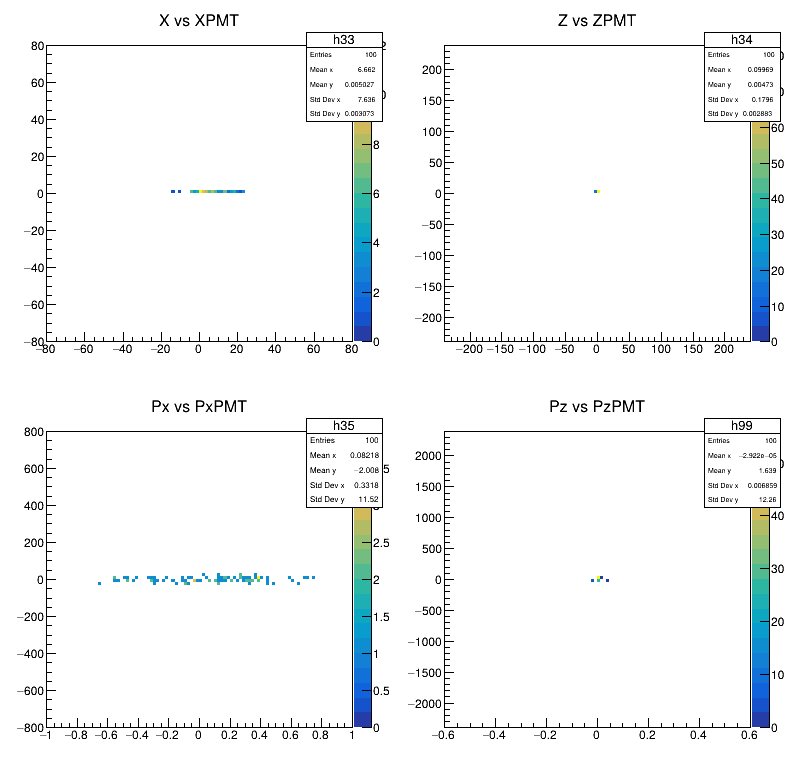

In [30]:
hx_vs_x = fdft.Filter("trigger2").Histo2D(("h33", "X vs XPMT", 100, -80.0, 80.0, 100, -80.0, 80.0),"anaBarXPMT","Prim_X");
hz_vs_z = fdft.Filter("trigger2").Histo2D(("h34", "Z vs ZPMT", 100, -240.0, 240.0, 100, -240.0, 240.0),"anaBarZPMT","Prim_Z");
hPx_vs_Px = fdft.Filter("trigger2").Histo2D(("h35", "Px vs PxPMT", 100, -1.0, 1.0, 100, -800.0, 800.0),"anaBarPXPMT","fPx");
hPz_vs_Pz = fdft.Filter("trigger2").Histo2D(("h99", "Pz vs PzPMT", 100, -0.6, 0.6, 100, -2400.0, 2400.0),"anaBarPZPMT","fPz");

c16 = root.TCanvas("c16","c16",800,800);
c16.Divide(2,2,0.01,0.01,0);

c16.cd(1);
hx_vs_x.Draw("COLZ");
c16.cd(2);
hz_vs_z.Draw("COLZ");
c16.cd(3);
hPx_vs_Px.Draw("COLZ");
c16.cd(4);
hPz_vs_Pz.Draw("COLZ");

c16.Draw();
c16.Print("plots/c16.pdf");

In [31]:
t.stop()

Elapsed time: 51.7918 seconds
